## Basics

In [43]:
import numpy as np
import scipy.stats as stats
import pymysql
import pandas as pd
import os

from collections import defaultdict
import paramiko


from sshtunnel import SSHTunnelForwarder
from collections import defaultdict
%matplotlib inline  
import seaborn as sns
import gzip

from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

In [48]:
def return_sign_in(login_loc = '/home/kel2158/login.txt'):
    login_dict = dict()
    with open(login_loc, "r") as file:
        for line in file.readlines():
            login_dict[ line.split(",")[0]] = line.split(",")[1].strip()
    return(login_dict)

login_dict = return_sign_in()

In [45]:
#Technically 2 binary outcomes (covid, negative covid OR hosp/not )
limit_to_covid = 1

database = "user_kel2158"
hhid_folder = '/home/kel2158/Projects/hhid_update/data/'
base_pedigree_folder = '/home/kel2158/Projects/Heritability_Base_Data/pedigree_v3_updated_results/'

#Figure output directory
figure_directory = '/home/kel2158/Projects/COVIDHerit/figures'

#Input files
filename_hhid =  hhid_folder+'hhid_trimmed_notcln.txt.gz'
filename_buildingid =  hhid_folder+'buildid_notcln.txt.gz'
finename_fam_input = base_pedigree_folder+ "family_v3.txt.gz"

output_folder= '/home/kel2158/Projects/COVIDHerit/data/12_29_21/'
covid_nopro_file = output_folder+'covid_noproband.txt.gz'
covid_file = output_folder+'covid.txt.gz'



In [49]:
server = SSHTunnelForwarder(
    '10.144.220.21',
    ssh_username='kel2158',
    ssh_password=login_dict['mimir_pw'],
    remote_bind_address=('127.0.0.1', 3306)
)
server.start()

db = pymysql.connect(
    host='127.0.0.1',
    port=server.local_bind_port,
    user=login_dict['user'],
    password=login_dict["db_pw"],
    db=database
)

cur = db.cursor()


In [50]:
cur.execute( "SET sql_mode=(SELECT REPLACE(@@sql_mode,'ONLY_FULL_GROUP_BY',''));" )

0

In [51]:
#Read in family file 
file_name = finename_fam_input
gfile = gzip.open(file_name)

fam_df = pd.read_csv(gfile,sep='\t')
mrn2famid = dict(zip (fam_df["ptid"],fam_df["famid"]))

In [52]:
#Read in hhid file (apt level)
file_name = filename_hhid
gfile = gzip.open(file_name)
hhid_df = pd.read_csv(gfile,sep='\t')


In [53]:
#Read in buildingID file (apt level)
file_name = filename_buildingid
gfile = gzip.open(file_name)
build_df = pd.read_csv(gfile,sep='\t')


In [54]:
#Read in time to first pcr trait file 
file_name = covid_nopro_file
gfile = gzip.open(file_name)
covnopro_df = pd.read_csv(gfile,sep='\t')


In [55]:
#Make relevant 
mrn2hhid = dict( zip( hhid_df["mrn"], hhid_df["trimmed_hhid"] ) )
mrn2buildid = dict( zip( build_df["mrn"], build_df["building_id"] ) )

In [56]:
#Equivalent to first_pcr_nohospreq_df in pull pheno script

#Get earliest PCR! Positive covid test for subsetting on patients that have
#gotten infected within 30 days of relative's infection
pull_data_query = """ SELECT DISTINCT pat_mrn_id, MIN(order_time) AS order_time, MAX(order_time)
                      FROM user_kel2158.covid_lab_table
                      WHERE test_result = "pos" 
                    GROUP BY pat_mrn_id;  """

cur.execute(pull_data_query)
rawdata = cur.fetchall()

db.close()
server.stop()


pheno_df = pd.DataFrame(list( rawdata ), columns=["mrn",
                           "order_time","latest_pcr_order_time"
                           ] )




In [57]:
def pull_fam_count( pheno, df, print_res = True, \
                   return_fams_df=False, type_pheno="binary_withproband",
                   return_patient_limited_df = False ):
    
    """Returns the number of families in a phenotype for SOLAR based on pheno 
     Needs phenotype column, famid column and ptid column"""    
    
    #subset on phenotype of interest and those in our pedigree
    df_phenosub = df[ (df["pheno"] == pheno ) 
                       &  (~df["famid"].isnull())] 
    
    #Get the total number of  members in each fam and then number of cases
    df_phenogrouped = df_phenosub.groupby( 'famid' )\
        .agg({ "ptid":"count","value":sum })\
        .reset_index()\
        .rename(columns={ "ptid":"num_fam_members","value":"num_cases" })
    
    #Subset to fams that will be included in SOLAR
    #ie has more than one family member an at least one case in each family
    if type_pheno == "binary_withproband":
        solar_fams_df = df_phenogrouped[ (df_phenogrouped["num_fam_members"] > 1) \
                                        & (df_phenogrouped["num_cases"] > 0) ]
    
    else:
         solar_fams_df = df_phenogrouped[ (df_phenogrouped["num_fam_members"] > 1)]
    
    solar_limited_df = df_phenosub[ df_phenosub["famid"].isin(solar_fams_df["famid"].unique())]
    solar_limited_df.drop_duplicates(inplace=True)
    solar_patients = set( solar_limited_df["ptid"] )
    
    
    
    if print_res:
            print(f'There are {len(solar_fams_df)} SOLAR families')
    
    if return_fams_df:
        return solar_fams_df, solar_patients
    
    elif return_patient_limited_df == True:
        return solar_limited_df
    
    else:
        return(len( solar_fams_df) )
    

In [58]:
pheno_df.rename(columns={"mrn":"ptid"},inplace=True)

In [59]:
#Add in controls
pheno_df = pd.concat([ pheno_df, covnopro_df[covnopro_df["value"] == 0]])

pheno_df["value"].fillna(1,inplace=True)

In [60]:
pheno_df["pheno"] = "covid_noproband"
pheno_df["famid"] = pheno_df["ptid"].map(mrn2famid)
pheno_df["hhid"] = pheno_df["ptid"].map(mrn2hhid)
pheno_df["buildid"] = pheno_df["ptid"].map(mrn2buildid)

In [61]:
#Subset to families used by solar (ie at least 2 patients per family)

solar_nopro_df = pull_fam_count("covid_noproband", pheno_df,\
                                return_patient_limited_df=True,type_pheno="no_proband")

There are 5676 SOLAR families


In [62]:
# Initialize a list to keep track of all figures
all_figures = []

# Create a function to save a figure and add it to the list
def save_and_track_figure(fig, filename, save_directory = figure_directory):
    # Combine the save_directory and filename to create the full path
    save_path = os.path.join(save_directory, filename)
    
    fig.patch.set_facecolor('white')
    # Save the figure with the full path
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    
    # Append the saved file path to the list of saved figures
    all_figures.append(save_path)



## Compare Shared Environment Groupings

In [95]:
#Limit to cases
pheno_cases_df = solar_nopro_df[ solar_nopro_df["value"] == 1 ]

group_dict = defaultdict(list)

samplesize_groupings_dict = dict()

for bubble in ["famid","buildid","hhid"]:
    
    time_from_last_pos = list()
    groups = pheno_cases_df.groupby(bubble)
    
    patients_n = 0
    
    for num,group in enumerate(groups):
        
        df = group[1]
        #If there is more than one individual in the group
        if len(df) > 1:
            
            patients_n += len(df)
            
            df.sort_values(by="order_time",inplace=True)
            counter = 0

            #For each first positive pcr test for a patient
            for subsequent_pcr_time in df["order_time"]:

                #If first in group continue
                if counter == 0:
                    counter += 1
                    last_pcr_time = subsequent_pcr_time
                    continue
                
                #If not first pos test get time from last group member's test
                else:
                    time_diff = subsequent_pcr_time - last_pcr_time
                    time_from_last_pos.append(time_diff.days)
                    counter += 1

                    last_pcr_time = subsequent_pcr_time
    
    group_dict[bubble] = time_from_last_pos
    samplesize_groupings_dict[bubble] = patients_n

In [96]:
samplesize_groupings_dict

{'famid': 485, 'buildid': 519, 'hhid': 269}

In [64]:
np.mean( group_dict["famid"] )

62.1796875

In [65]:
np.std( group_dict["famid"] )

121.15188901706132

In [66]:
np.mean( group_dict["hhid"] )

33.44285714285714

In [67]:
np.std( group_dict["hhid"] )

97.59678503403477

In [68]:
np.mean( group_dict["buildid"] )

93.45578231292517

In [69]:
np.std( group_dict["buildid"] )

137.32905174419363

In [70]:
#See if there is a difference
f_val, p_val = stats.f_oneway( group_dict["hhid"],
                              group_dict["famid"],
                              group_dict["buildid"])

In [71]:
print( "f value: ",f_val)
print( "p value: ",p_val)

f value:  11.770135799891959
p value:  9.417194371448607e-06


In [72]:
def get_95_ci(data1,data2):
    #n greater than 30 so use z score for 95% ci (1.96())
    #ci for difference of the means
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    
    n1 = len(data1)
    n2 = len(data2)
    
    sd1 = np.std(data1)
    sd2 = np.std(data2)
    
    pooled_sd = ( (n1-1)*sd1 + (n2-1)*sd2 )/ (n1+n2-2)

    
    high_ci = (mean1-mean2) + 1.96*pooled_sd*(1/n1 + 1/n2)**.5
    low_ci = (mean1-mean2) - 1.96*pooled_sd*(1/n1 + 1/n2)**.5
    
    degrees_freedom = n1+n2-2
    
    return(high_ci,low_ci,degrees_freedom)

In [99]:
#perform two sample t-test hhid vs famid
stats.ttest_ind(a=group_dict["famid"], b=group_dict["hhid"], equal_var=False)

Ttest_indResult(statistic=2.559206532596979, pvalue=0.01092357015218149)

In [74]:
get_95_ci(group_dict["famid"],group_dict["hhid"])

(51.98505650555608, 5.488604208729633, 394)

In [75]:
#perform two sample t-test hhid vs buildID
stats.ttest_ind(a=group_dict["buildid"], b=group_dict["hhid"], equal_var=False)

Ttest_indResult(statistic=5.205890036846074, pvalue=3.215389623116209e-07)

In [76]:
get_95_ci(group_dict["buildid"],group_dict["hhid"])

(85.07915093468498, 34.94669940545107, 432)

In [77]:
#perform two sample t-test famid vs buildID
stats.ttest_ind(a=group_dict["famid"], b=group_dict["buildid"], equal_var=False)

Ttest_indResult(statistic=-2.8324634274599827, pvalue=0.004789060501311233)

In [78]:
get_95_ci(group_dict["buildid"],group_dict["famid"])

(53.02427899922239, 9.52791062662794, 548)

In [79]:
#Create dataframe for graphing
shared_env_df = pd.DataFrame( list( zip( group_dict["hhid"], len(group_dict["hhid"]) * ["hhid"]) ) +\
list( zip( group_dict["famid"], len(group_dict["famid"]) * ["famid"]) ) +\
list( zip( group_dict["buildid"], len(group_dict["buildid"]) * ["buildid"]) ),\
                               columns=["Time to Last Pos PCR","Shared Environment Grouping"] )


shared_env_df["Shared Environment Grouping"].replace( {"hhid":"Household",
                                                      "famid":"Family",
                                                      "buildid":"Building"},inplace=True)

In [80]:
#Manuscript figure width requirements
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
figsize_2colw = 175/25.4
figsize_1colw= 85/25.4

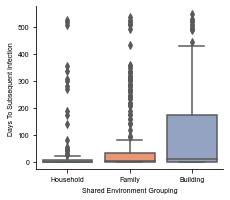

In [100]:

fig, ax = plt.subplots(figsize=(figsize_1colw,3))

sns.boxplot(data=shared_env_df, x="Shared Environment Grouping", y="Time to Last Pos PCR",palette="Set2",\
                 order=[ "Household","Family","Building"])\
.set( 
    ylabel='Days To Subsequent Infection',
    xlabel='Shared Environment Grouping'
)
sns.despine()


save_and_track_figure(fig, "shared_env_comparison.pdf")